# Chapter 5 - Applying Convnets to The Dogs vs Cats

In [34]:
# Importing PlaidML. Make sure you follow this order
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [35]:
from keras.datasets import mnist
from keras import models, layers
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import shutil
import os

import matplotlib.pyplot as plt

In [23]:
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

## Loading dataset

In [24]:
if 'DATASET_CATS_DOGS' in os.environ:
    original_dataset_dir = os.environ['DATASET_CATS_DOGS']
else:
    original_dataset_dir = "/Users/adriano.gil/workspace/datasets/dogs-vs-cats/train/"

if 'DATASET_CATS_DOGS_SMALL' in os.environ:
    base_dir = os.environ["DATASET_CATS_DOGS_SMALL"]
else:
    base_dir = "/Users/adriano.gil/workspace/datasets/dogs-vs-cats-small"
create_dir(base_dir)

In [25]:
train_dir = os.path.join(base_dir, 'train')
create_dir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
create_dir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
create_dir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
create_dir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
create_dir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
create_dir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
create_dir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
create_dir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
create_dir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [26]:
print('Total training cat images: ', len(os.listdir(train_cats_dir)))
print('Total training dog images: ', len(os.listdir(train_dogs_dir)))
print('Total validation cat images: ', len(os.listdir(validation_cats_dir)))
print('Total validation dog images: ', len(os.listdir(validation_dogs_dir)))
print('Total test cat images: ', len(os.listdir(test_cats_dir)))
print('Total test dogs images: ', len(os.listdir(test_dogs_dir)))

Total training cat images:  1000
Total training dog images:  1000
Total validation cat images:  500
Total validation dog images:  500
Total test cat images:  500
Total test dogs images:  500


## Preparing data

In [30]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Generating Models

In [27]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizers.RMSprop(lr=1e-4),
        loss='binary_crossentropy',
        metrics=['acc']
    )
    return model

In [28]:
model = build_model()
model.summary()

W0504 14:14:58.950469 4524492224 deprecation_wrapper.py:119] From /Users/adriano.gil/.virtualenvs/pydeep/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
______________________

## Training model

In [36]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)
model.save('catas_and_dogs_small_1.h5')

Epoch 1/30
100/100 [==============================] - 38s 377ms/step - loss: 0.0286 - acc: 0.9915 - val_loss: 1.1087 - val_acc: 0.7370
Epoch 2/30
100/100 [==============================] - 37s 369ms/step - loss: 0.0215 - acc: 0.9955 - val_loss: 1.1674 - val_acc: 0.7400
Epoch 3/30
100/100 [==============================] - 37s 370ms/step - loss: 0.0196 - acc: 0.9930 - val_loss: 1.2859 - val_acc: 0.7050
Epoch 4/30
100/100 [==============================] - 37s 372ms/step - loss: 0.0276 - acc: 0.9910 - val_loss: 1.2046 - val_acc: 0.7370
Epoch 5/30
100/100 [==============================] - 39s 391ms/step - loss: 0.0138 - acc: 0.9975 - val_loss: 1.2824 - val_acc: 0.7240
Epoch 6/30
100/100 [==============================] - 39s 388ms/step - loss: 0.0118 - acc: 0.9980 - val_loss: 1.2924 - val_acc: 0.7500
Epoch 7/30
100/100 [==============================] - 38s 379ms/step - loss: 0.0107 - acc: 0.9970 - val_loss: 1.4225 - val_acc: 0.7260
Epoch 8/30
100/100 [==============================] - 3

## Displaying curves of loss and accuracy during training

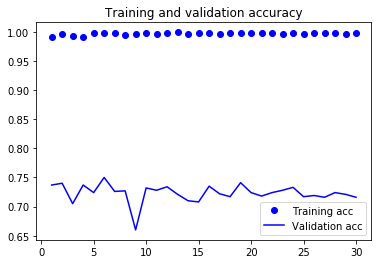

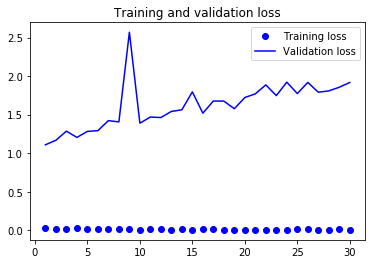

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
